In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Retrieve the images
Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

The directory contains 5 sub-directories, one per class:

In [3]:
import pathlib
data_dir = tf.keras.utils.get_file(origin= 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                      fname ='flower_photos', untar=True)

data_dir = pathlib.Path(data_dir)


228818944/228813984 [==============================] - 8s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt'])
CLASS_NAMES

array(['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips'],
      dtype='<U10')

Each directory contains images of that type of flower. Here are some roses:

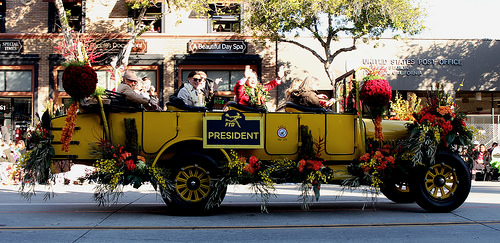

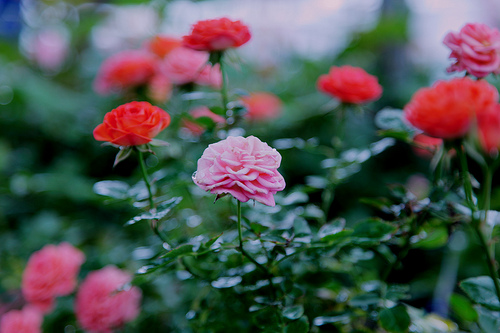

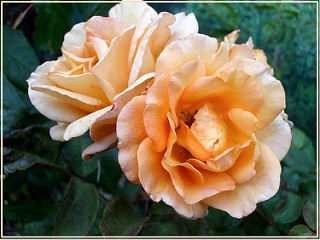

In [11]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

# Load using keras.preprocessing

A simple way to load images is to use tf.keras.preprocessing.

In [12]:
#the 1./255 is to convert from uint8 to float32 in range [0,1]
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [13]:
#define some parameters for the loader
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [14]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [43]:
#inspect a batch
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

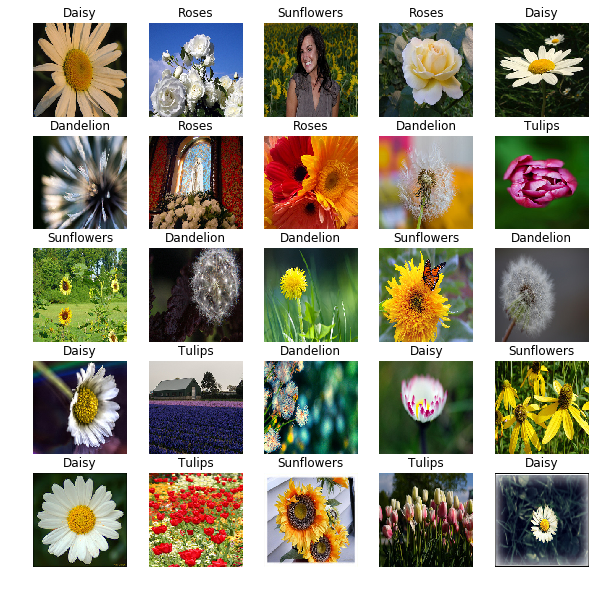

In [35]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch,label_batch)

# Load using tf.data
The above keras.preprocessing method is convienient, but has three downsides:

1) It's slow. See the performance section below.

2) It lacks fine-grained control.

3) It is not well integrated with the rest of TensorFlow.


To load the files as a tf.data.Dataset first create a dataset of the file paths:

In [17]:
 list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [19]:
for f in list_ds.take(5):
    print(f.numpy())

b'/Users/justintennenbaum/.keras/datasets/flower_photos/roses/5089363428_2c5a1272ea.jpg'
b'/Users/justintennenbaum/.keras/datasets/flower_photos/tulips/100930342_92e8746431_n.jpg'
b'/Users/justintennenbaum/.keras/datasets/flower_photos/daisy/5608389827_a42a46f760.jpg'
b'/Users/justintennenbaum/.keras/datasets/flower_photos/sunflowers/7369484298_332f69bd88_n.jpg'
b'/Users/justintennenbaum/.keras/datasets/flower_photos/daisy/14167543177_cd36b54ac6_n.jpg'


Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

In [20]:
def get_label(file_path):
    #convert path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    #second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [21]:
def decode_img(img):
    #onverts the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    #use convert_image_dtype to conver floats in the [0,1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [22]:
def process_path(file_path):
    label = get_label(file_path)
    #load the raw data fromt he file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Use Dataset.map to create a dataset of image, label pairs:

In [27]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [28]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False  True False False]


Basic methods for training
To train a model with this dataset you will want the data:

- To be well shuffled.

- To be batched.

- Batches to be available as soon as possible.

These features can be easily added using the tf.data api.

In [51]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    #This is a small dataset, only load it once and keep it in memory
    #use .cache(filename) to cache the preprocessing work for datasets that fit in memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    #repeat forever
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    #prefetch lets the dataset fetch batches in the background while the models training
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [52]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

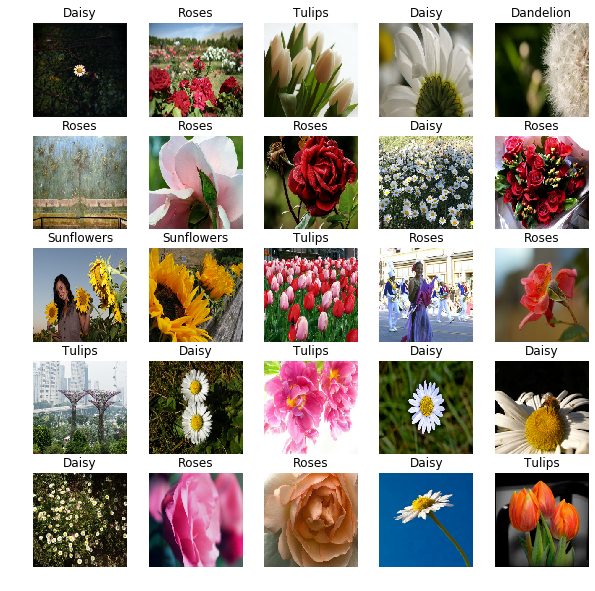

In [53]:
show_batch(image_batch.numpy(),label_batch.numpy())

# Performance
To investigate, first here's a function to check the performance of our datasets:



In [55]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i %10 == 0:
            print('.',end='')
    print()
    end = time.time()
    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

Lets compare the speed of the two

In [57]:
#keras.preprocessing
timeit(train_data_gen)

....................................................................................................
1000 batches: 110.99785423278809 s
288.29386 Images/s


In [58]:
# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 18.99570608139038 s
1684.59124 Images/s


In [59]:
#A large part of the performance gain comes from the use of .cache.
uncached_ds = prepare_for_training(labeled_ds,cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 77.73759007453918 s
411.64127 Images/s


In [60]:
#If the dataset doesn't fit in memory use a cache file to maintain some of the advantages:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 72.60875701904297 s
440.71819 Images/s
